# Описание процесса
Есть производство некотрого продукта посредством электролиза (нагреваемый ящик, стоит в неотапливаемом помещении).
Заглядывать в ящик часто нельзя - лабораторный сбор по уточнению процентного содержания в смеси происходит дважды в день, хотелось бы делать замеры еще реже  и в перспективе полагатсья только на модель - отсюда и задача. Требуется предсказать по данным (до 2018-10-18) с различных датчиков процентное содержание продукта в смеси файл `target.csv`.
## В качестве данных доступны

**Файл `3min_series.csv`**:

- `Шум` в электрике
- `Обратная ЭДС` сети устройства
- `Ср.прир.напр` Средний прирост напряжения в сети
- `Сум.доз АПГ` Сумма доз АПГ (происходит периодичный вброс добавки в ящик - это число соответствует кол-ву раз которое производилось вбрасывание за промежуток времени)
- Температурные датчики (ящик прямоугольной формы, они рсполагаются по всему периметру, см `boards.png` - схематическое расположение, нумерация вдоль длины ящика дана как пример)
	- `Board Temp. {i}` - датчики температуры по длинне ящика с обоих сторон
	- `Board Face Temp. {1,6}` - датчики с лицевой стороны
	- `Board Deaf Temp. {1,6}` - датчики с тыльной стороны

**Файл `Средняя масса доли АПГ New`** : массовые доли каждого из вбросов показателя `Сумма доз АПГ`. То есть можно понять сколько массы было вброшено в период `Итог масс АПГ = Сум.доз АПГ * avg_mass_apg`.

## Критерии успешности выполнения задания:
- Получение инсайтов по данным
- Обоснованное построение модели и ее оценка
- bonus: модель завернута в модуль / сервис / приложение

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import randint

In [2]:
df = pd.read_csv("3min_series.csv")
df_y = pd.read_csv("target.csv", sep=";")

In [3]:
df.Date = pd.to_datetime(df.Date)

In [4]:
df_y.loc[:, "Date"] = pd.to_datetime(df_y["Unnamed: 0"])
df_y.drop("Unnamed: 0", axis=True, inplace=True)

In [5]:
df = df.set_index(df.Date.apply(lambda x: x.strftime("%Y-%m-%d-%p")))
df_y = df_y.set_index(df_y.Date.apply(lambda x: x.strftime("%Y-%m-%d-%p")))
df.loc[:, "product_percents"] = df_y.product_percents
del(df_y)

In [6]:
flt = ~df["Board Temp. 1"].isnull() & ~df["Шум"].isnull() & ~df["Ср.прир.напр."].isnull()

In [7]:
X_train = df.loc[flt & (df.Date < "2018-10-18") & ~df.product_percents.isnull()]
X_test = df.loc[flt & (df.Date > "2018-10-18")]

In [8]:
X_test.shape, X_train.shape

((12321, 20), (28130, 20))

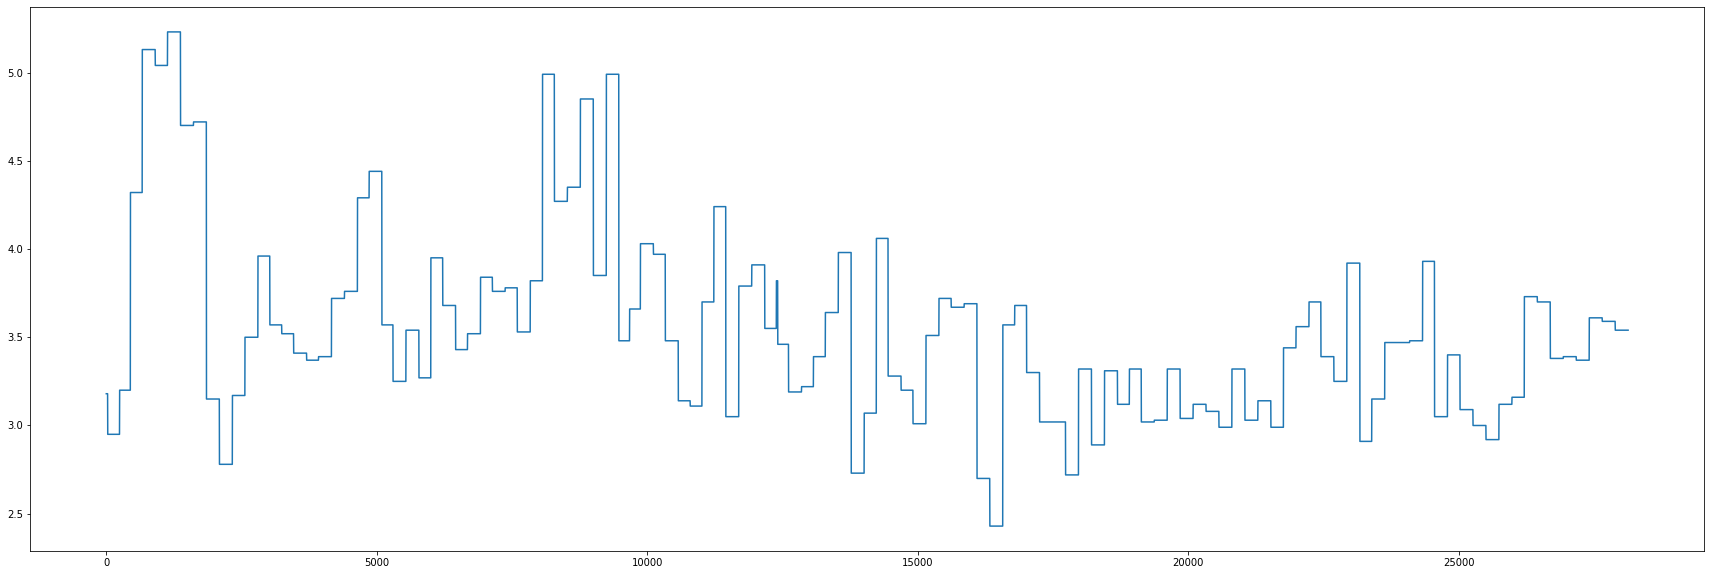

In [9]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(X_train)), X_train.product_percents);

In [10]:
board_columns = ["Board Temp. 1",
                 "Board Temp. 2",
                 "Board Temp. 3",
                 "Board Temp. 4",
                 "Board Temp. 5",
                 "Board Temp. 6",
                 "Board Temp. 7",
                 "Board Temp. 8",
                 "Board Temp. 9",
                 "Board Temp. 10"]
board_columns_f = ["Board Face Temp. 1",
                   "Board Face Temp. 6"]
board_columns_d = ["Board Deaf Temp. 1",
                   "Board Deaf Temp. 6"]

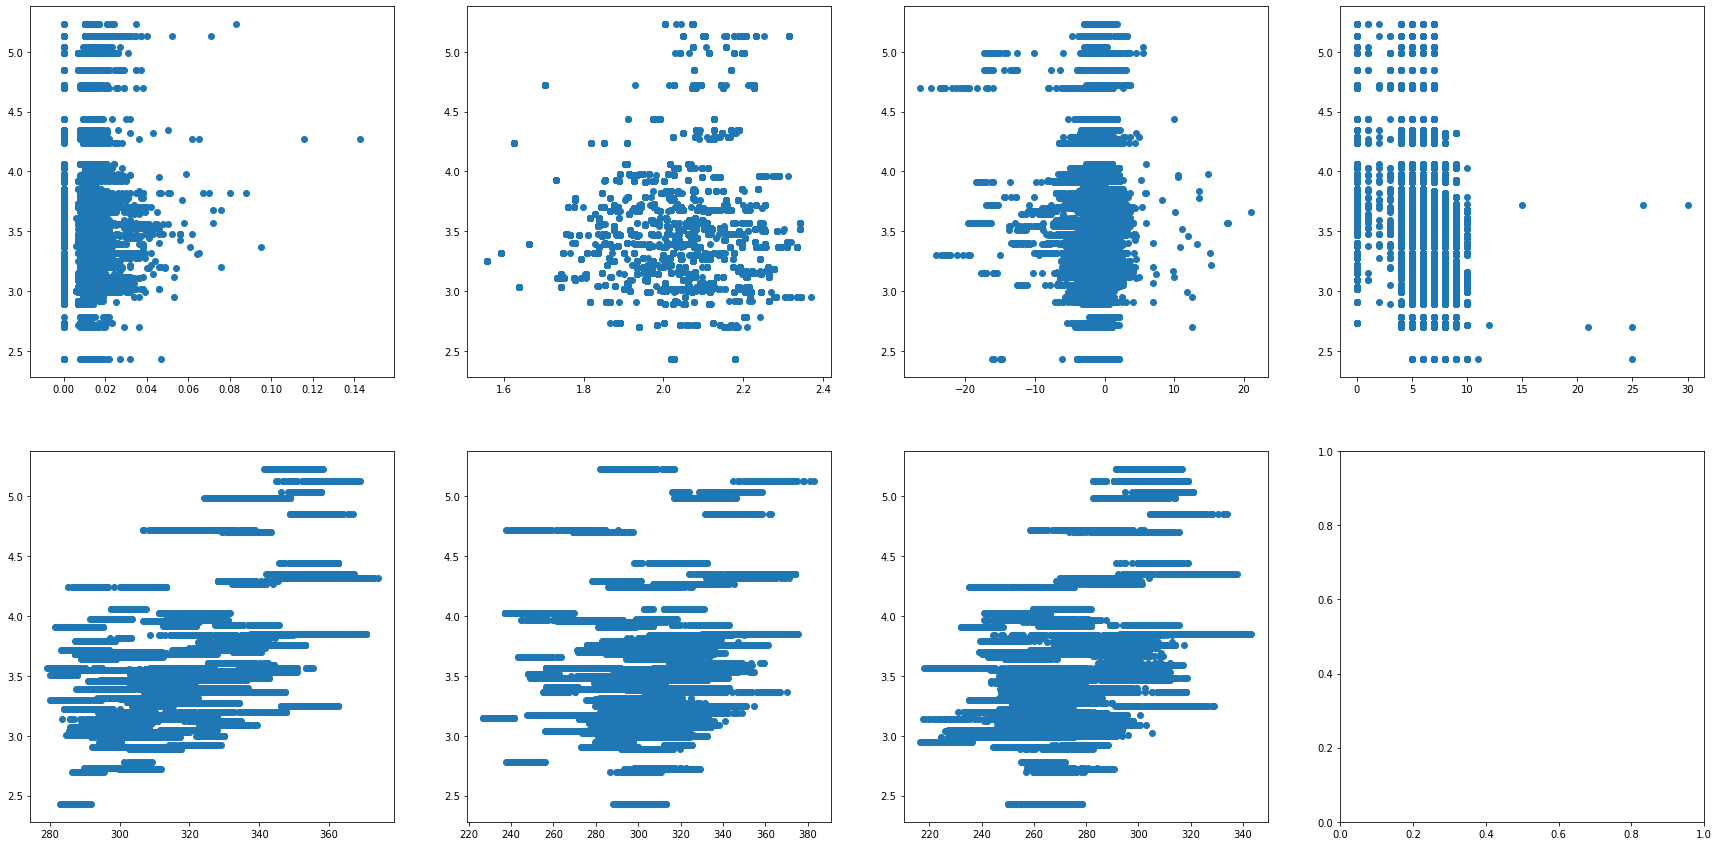

In [11]:
fig, plts = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
plts[0][0].scatter(X_train["Шум"], X_train.product_percents)
plts[0][1].scatter(X_train["Обратная ЭДС"], X_train.product_percents)
plts[0][2].scatter(X_train["Ср.прир.напр."], X_train.product_percents)
plts[0][3].scatter(X_train["Сум.доз АПГ"], X_train.product_percents)
plts[1][0].scatter(X_train[board_columns].apply(lambda x: x.mean(), axis=1), X_train.product_percents)
plts[1][1].scatter(X_train[board_columns_f].apply(lambda x: x.mean(), axis=1), X_train.product_percents)
plts[1][2].scatter(X_train[board_columns_d].apply(lambda x: x.mean(), axis=1), X_train.product_percents);

In [12]:
# X_train.loc[:, "temp_mean"] = X_train[board_columns + board_columns_f + board_columns_d].apply(lambda x: x.mean(), axis=1)

In [13]:
cost = lambda y_, y: 1/len(y) * sum((y_-y)**2)

def gradient(df_, std, mean):
    X = df_.drop(["product_percents", "Date"], axis=True)
    y = df_.product_percents
    X = ((X-X.mean())/X.std()).values
    y = ((y-y.mean())/y.std()).values

    epoch = 60000
    step = 100
    w = [0] * X.shape[1]
    errs = []
    for e in range(epoch):
        s = X.shape[0]
        i = randint(0, s-1)
        w -= (step/(s+10*e) * (X[i].dot(w)-y[i])) * (X[i])
        errs.append(cost(X[0:100].dot(w), y[0:100]))
    print(sum((X.dot(w)-y)**2)/len(y))
    return w, X.dot(w) * std + mean, errs

In [14]:
w, X, errs = gradient(X_train, X_train.product_percents.std(), X_train.product_percents.mean())

0.48303064084241254


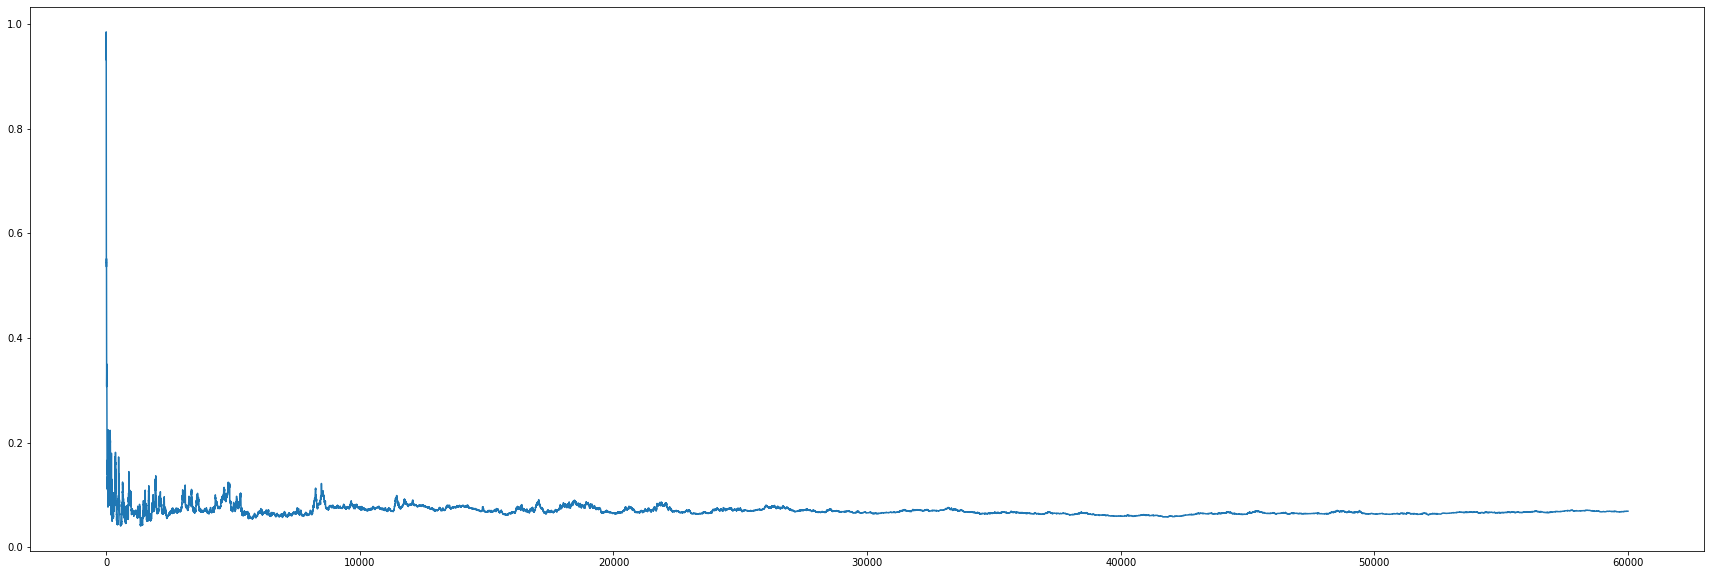

In [15]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(errs)), errs);

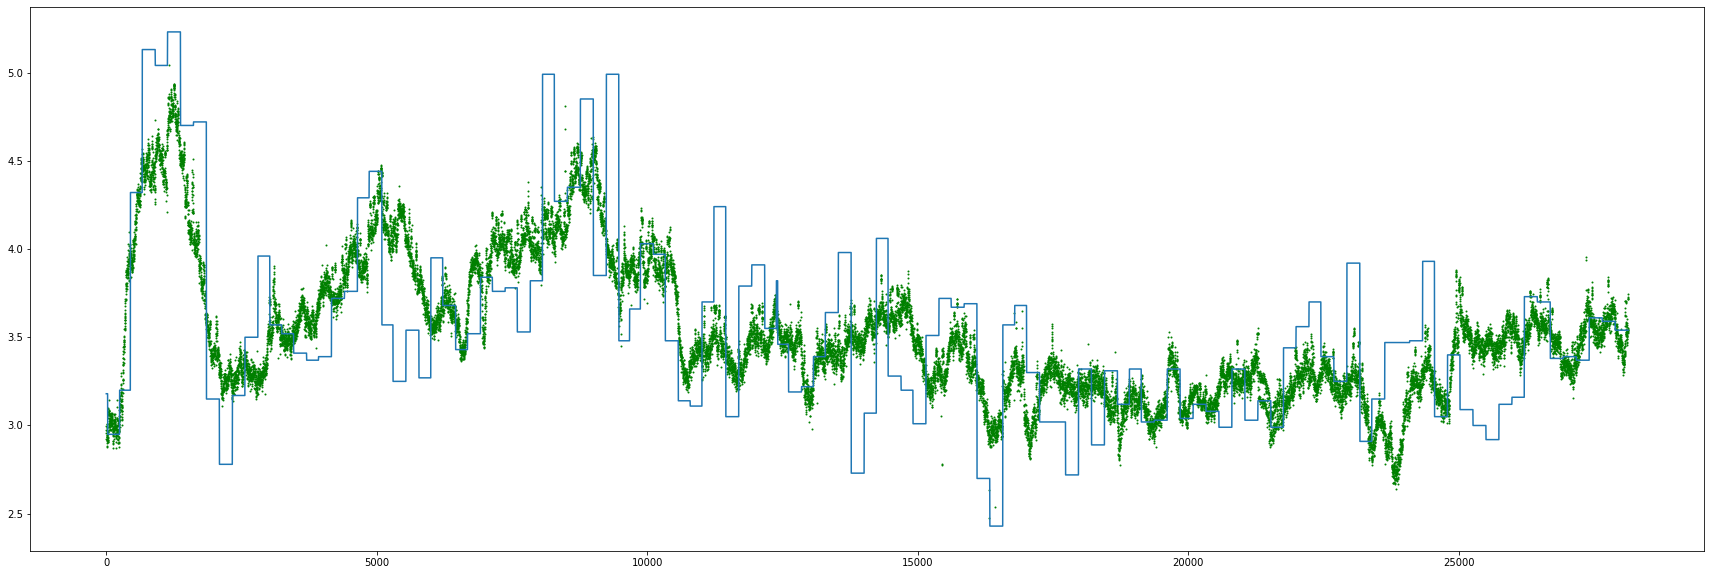

In [19]:
plt.figure(figsize=(30, 10))
plt.scatter(range(len(X_train)), X, c="g", s=1)
plt.plot(range(len(X_train)), X_train.product_percents);

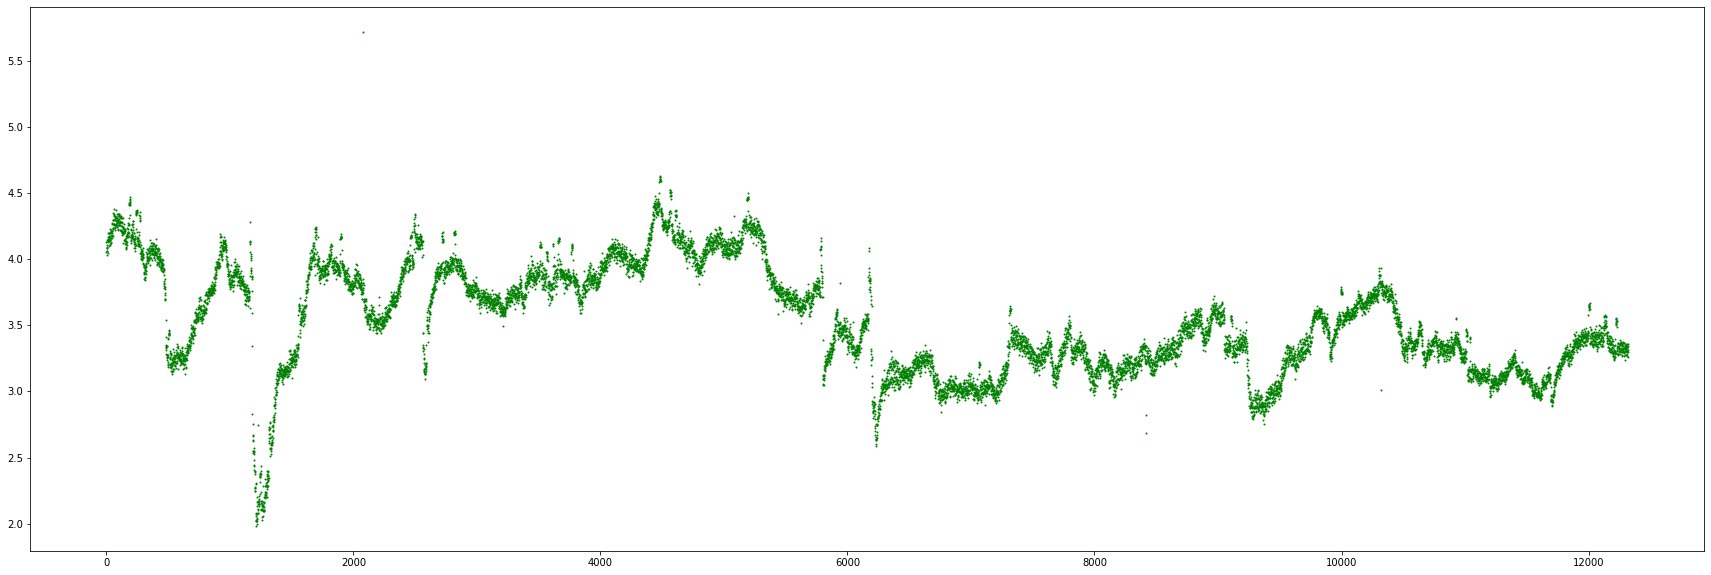

In [21]:
X = X_test.drop(["product_percents", "Date"], axis=True)
X = ((X-X.mean())/X.std()).values


X_w = X.dot(w) * X_train.product_percents.std() + X_train.product_percents.mean()

plt.figure(figsize=(30, 10))
plt.scatter(range(len(X_test)), X_w, c="g", s=1);

In [22]:
np.savetxt("y_test.csv", X_w)